# Обучение модели сегментации FCN ResNet50

## Dataset

Мы будем использовать Oxford-IIIT Pet Dataset. Он состоит из 37 классов собак и кошек, на каждый класс около 200 картинок. В датасете есть как боксы и маски. В датасете около 7 тысяч изображений.  

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Скачаем данные и распакуем

In [1]:
%%capture out
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

## Импортируем нужные библиотеки

In [2]:
%%capture out
!pip install albumentations torchmetrics pytorch_lightning -U

In [3]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

In [4]:
os.listdir()

['.config',
 'annotations.tar.gz',
 'images',
 'images.tar.gz',
 'annotations',
 'sample_data']

## Готовим данные

Каждый пиксель изображения маски может принимать одно из трех значений: «1», «2» или «3». «1» означает, что данный пиксель изображения принадлежит классу «животное», «2» - классу «фон», «3» - классу «граница». Поскольку в этом примере демонстрируется задача двоичной сегментации (то есть присвоение одного из двух классов каждому пикселю), мы предварительно обработаем маску, поэтому она будет содержать только два уникальных значения: 0 если пиксель является фоном, и 1 если пиксель - это животное или граница.

In [5]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [6]:
class PetDataset(Dataset):
    def __init__(self, split="train", transform=None):
        images_train, images_test = train_test_split(
            os.listdir("images"), random_state=142, shuffle=True, train_size=0.8
        )
        if split == "train":
            self.images_filenames = images_train
        else:
            self.images_filenames = images_test

        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join("images", image_filename))
        if image is None:
            return self.__getitem__(idx + 1 if self.__len__() <= idx + 1 else 0)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(
                "annotations", "trimaps", image_filename.replace(".jpg", ".png")
            ),
            cv2.IMREAD_UNCHANGED,
        )
        if mask is None:
            return self.__getitem__(idx + 1 if self.__len__() <= idx + 1 else 0)

        mask = preprocess_mask(mask)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [7]:
train_dataset = PetDataset()
val_dataset = PetDataset(split="val")

### Визуализация и аугментация

Раздел для самопроверки, визуализации аугментированных данных и пр.

In [8]:
def display_few_examples_from_data(dataset, n=4):
    figure, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 24))
    for i in range(n):
        image, mask = dataset.__getitem__(i)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

In [10]:
train_transform = A.Compose(
    [
        A.Resize(512, 512),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # ToTensorV2(),
    ]
)
train_dataset = PetDataset(
    "train",
    transform=train_transform,
)

val_transform = A.Compose(
    [
        A.Resize(512, 512)
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #ToTensorV2()
    ]
)
val_dataset = PetDataset("Val", transform=train_transform)

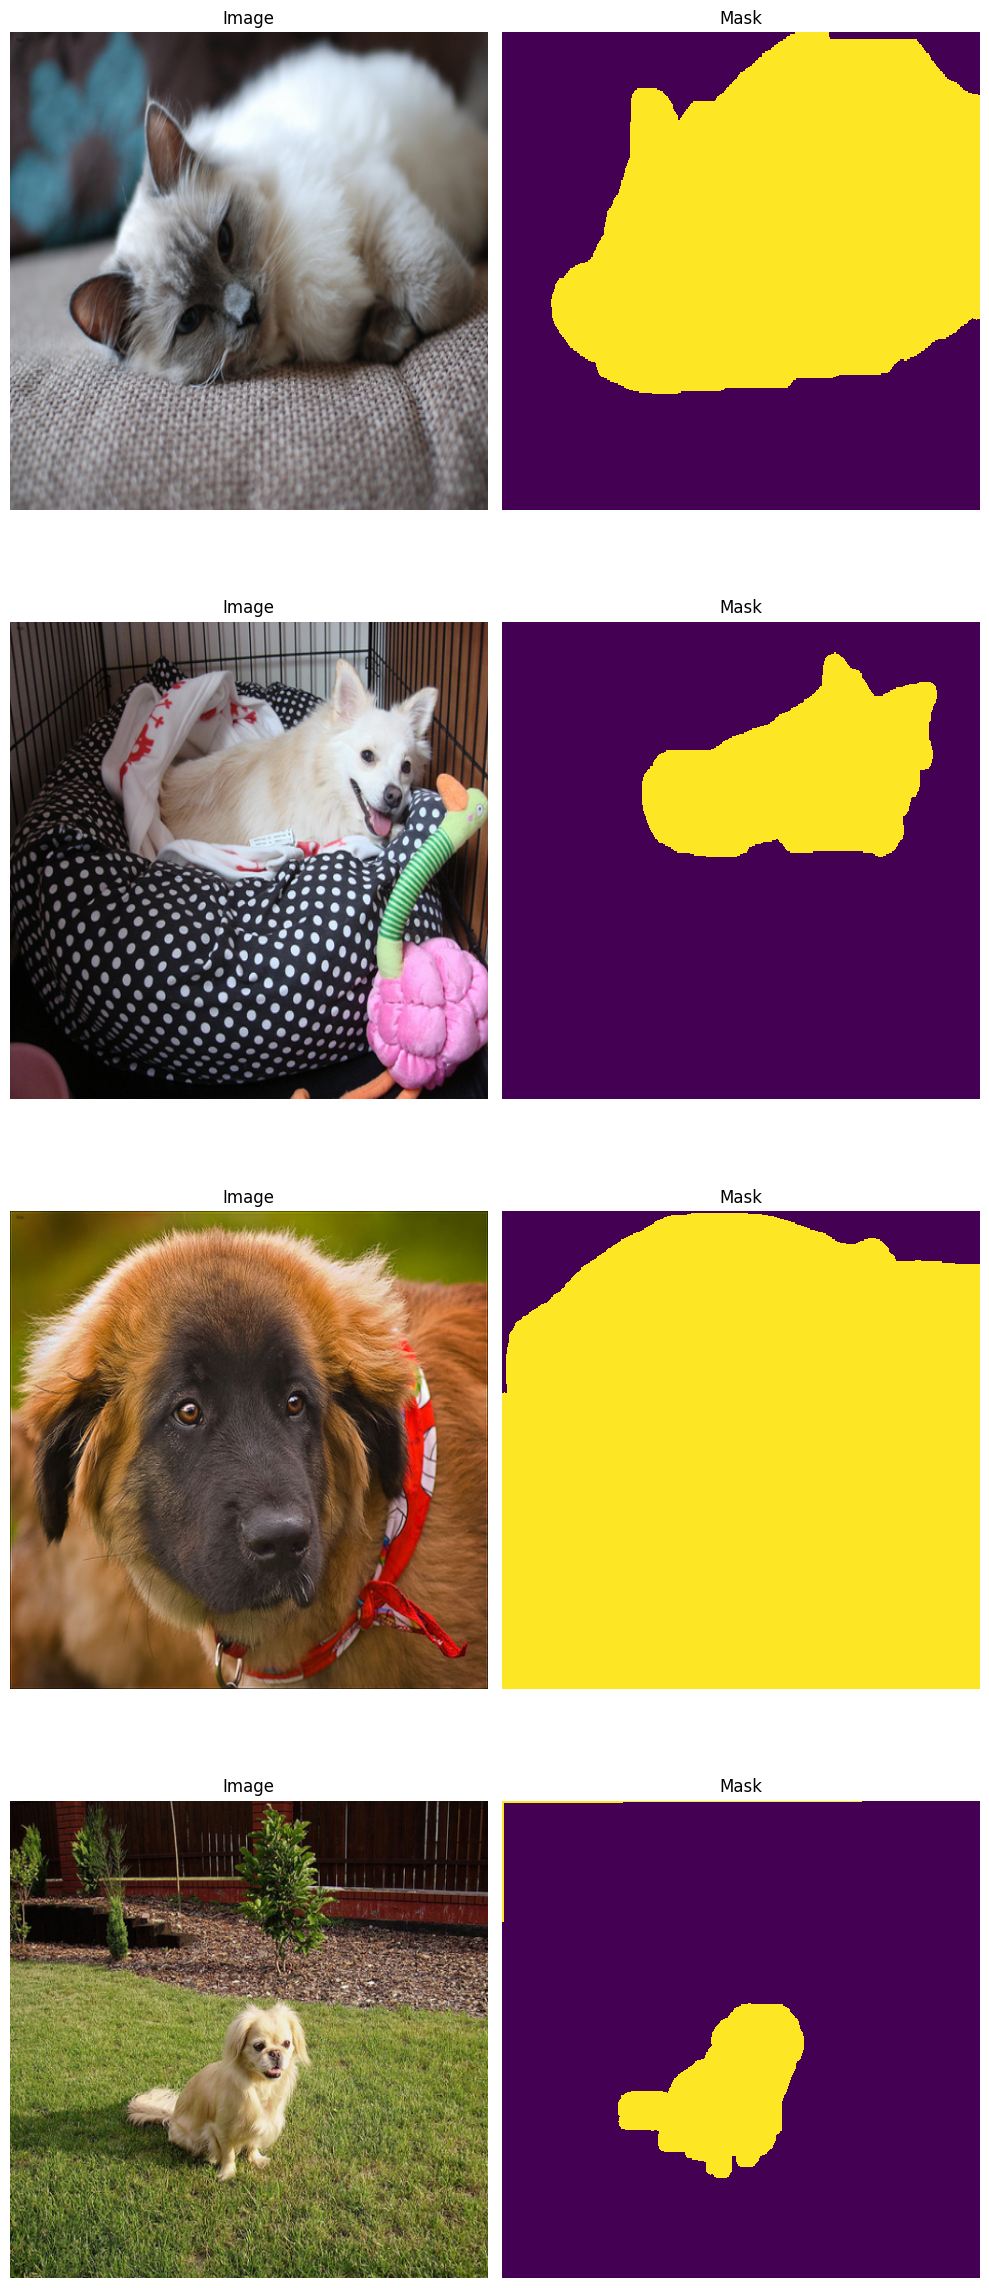

Validation dataset


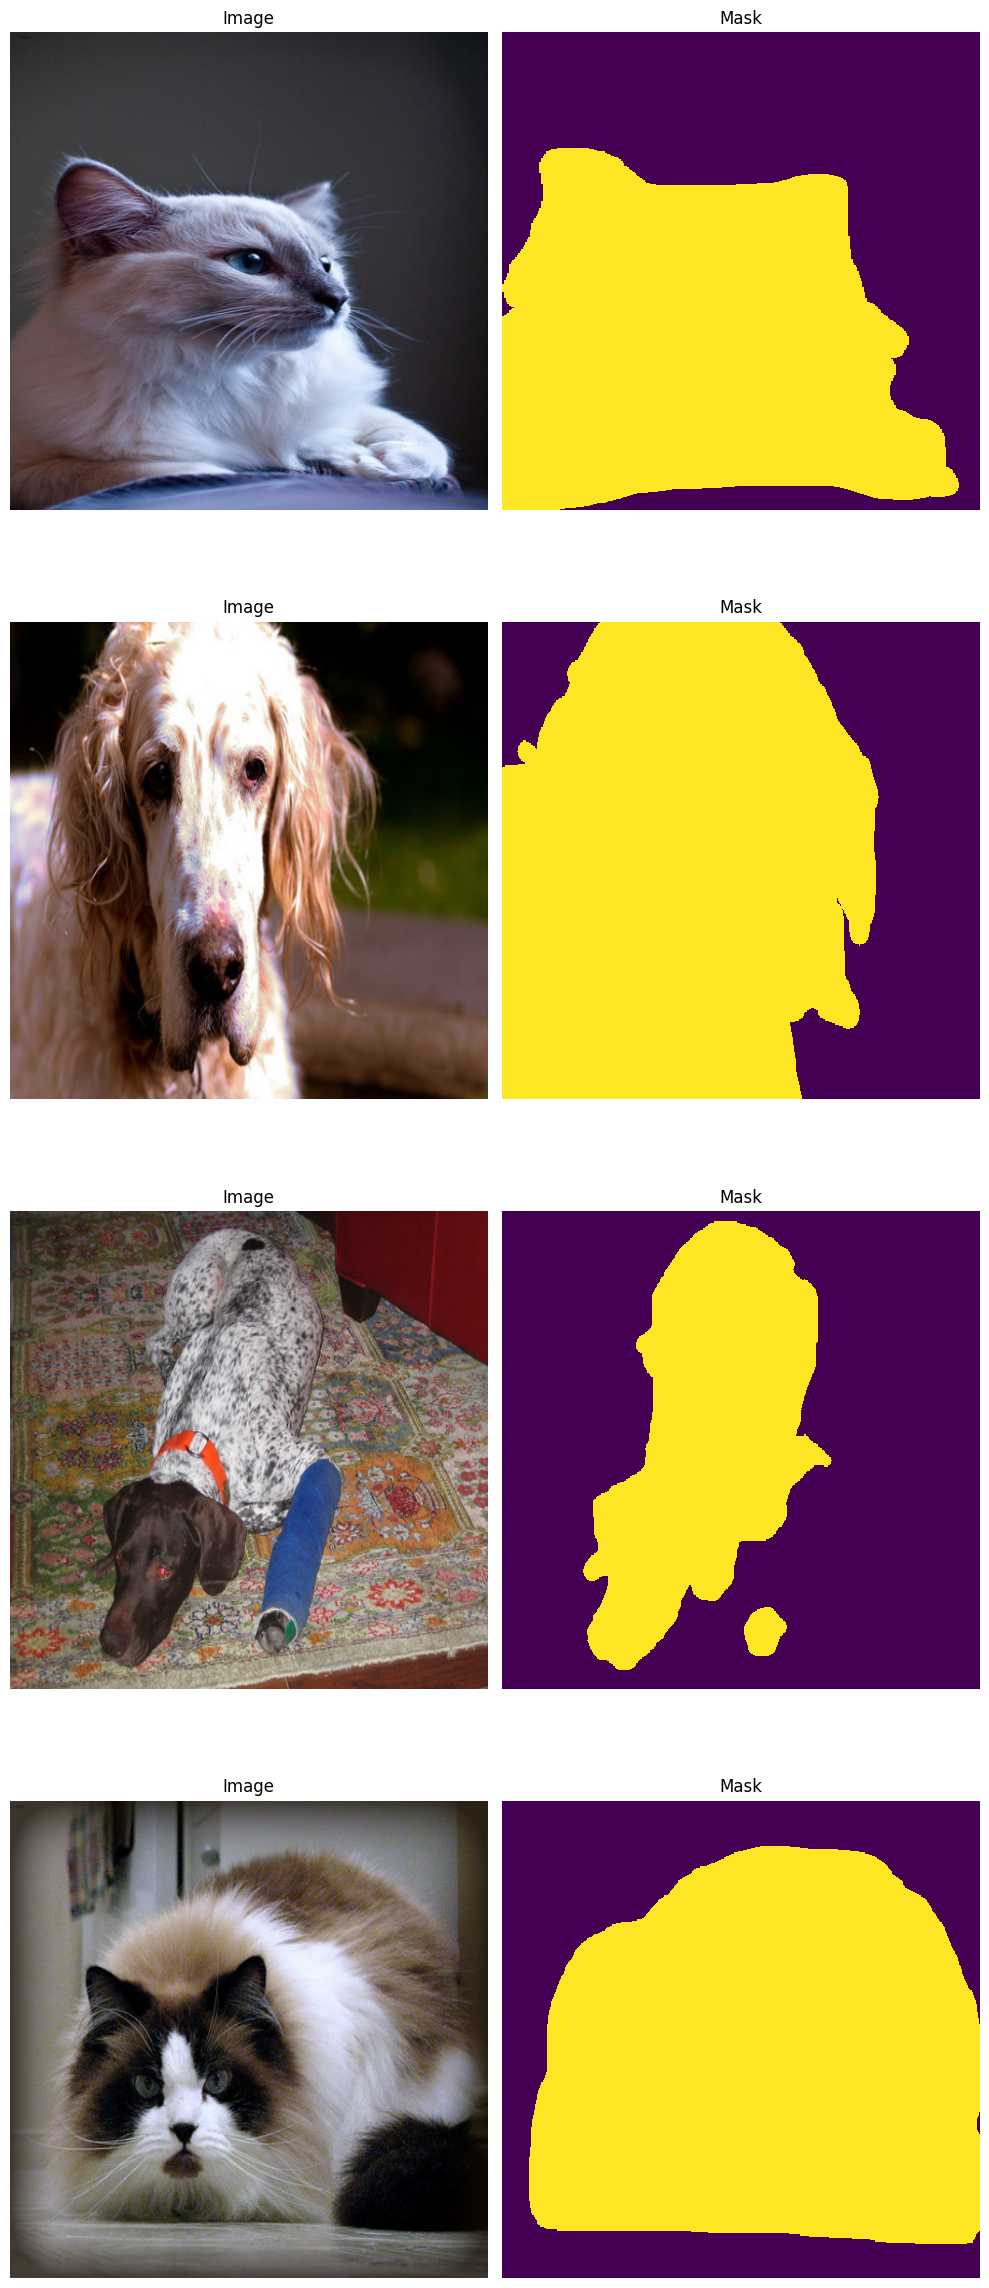

In [11]:
display_few_examples_from_data(train_dataset)
print("Validation dataset")
display_few_examples_from_data(val_dataset)

### Датасеты

In [12]:
train_transform = A.Compose(
    [
        A.Resize(512, 512),
     # Заполни своими
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = PetDataset(
    "train",
    transform=train_transform,
)

val_transform = A.Compose(
    [
        A.Resize(512, 512),
     # Заполни своими
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = PetDataset("Val", transform=train_transform)

## Модель и обучение

In [13]:
def IoU(preds, targs, eps: float = 1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]

    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = (torch.eye(num_classes + 1).to(device) # изменено
                      [targs.squeeze(1).to(torch.int64)])
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)

    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = (torch.eye(num_classes).to(device) # изменено
                      [targs.squeeze(1).to(torch.int64)])

        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()

        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)

    true_1_hot = true_1_hot.type(preds.type())

    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)  # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()  # find mean of class IoU values
    return iou

In [14]:
# Возьмем модель FCN_ResNet50, посмотрим размерность входных слоев классификаторов
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights, progress=False)

print(model.classifier)
print(model.aux_classifier)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
)
FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
)


In [15]:
class SegModel(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset):
        super(SegModel, self).__init__()
        self.batch_size = 8
        self.learning_rate = 1e-4
        #self.net = unet_model((512, 512), 1) #SomeModel(n_classes=1)
        '''
        Added
        '''
        self.net = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT, progress=False)
        self.net.classifier[4] = nn.Conv2d(512,1,kernel_size=(1,1),stride=(1,1))
        self.net.aux_classifier[4] = nn.Conv2d(256,1, kernel_size=(1,1),stride=(1,1))
        '''
        -----
        '''

        self.trainset = train_dataset
        self.valset = val_dataset
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        out = self.forward(img)['out'] # [B, 1, H, W] Изменено
        loss_val = self.criterion(out.squeeze(1), mask.float()) # [B, 1, H, W] -> # [B, H, W] Изменено
        iou_score = IoU(out.float(), mask.long())
        self.log("train_loss", loss_val)
        self.log("train_iou", iou_score, prog_bar=True)
        return loss_val

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

        return [opt], [sch]

    def train_dataloader(self):
        return DataLoader(self.trainset,
                          batch_size=self.batch_size,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=1, shuffle=False) # изменено

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)['out'] # изменено
        loss_val = self.criterion(out.squeeze(1), mask.float()) # изменено
        iou_score = IoU(out.float(), mask.long())
        self.log("val_loss", loss_val, prog_bar=True)
        self.log("val_iou", iou_score, prog_bar=True, on_epoch=True)

### Обучение

In [16]:
model = SegModel(train_dataset, val_dataset)

trainer = pl.Trainer(
    #gpus=1,
    # tpu_cores=1,
    max_epochs=50,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_iou"),
        LearningRateMonitor("epoch"),
        EarlyStopping(monitor="val_iou", mode="max", patience=15),
    ],  # Log learning rate every epoch
    #progress_bar_refresh_rate=1,
)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | net       | FCN               | 35.3 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.227   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


### Валидация

In [19]:
trainer.validate(
    model,
    ckpt_path='/content/lightning_logs/version_0/checkpoints/epoch=3-step=2956.ckpt',
    dataloaders=model.val_dataloader()
    )

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=3-step=2956.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=3-step=2956.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.7513414621353149     │
│         val_loss          │    0.09331664443016052    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.09331664443016052, 'val_iou': 0.7513414621353149}]

Всего пяти эпох хватило, чтобы поднять IoU на валидационной выборке до 0.75.